In [1]:
import sys
import os
import numpy as np
import numpy.linalg as la
import torch

from ControlRF import GPController, ADPKernel, ADPRandomFeatures, ADKernel, ADRandomFeatures, VanillaKernel, VanillaRandomFeatures
from ControlRF.plots import *
from ControlRF.util import data_gen

import core
from core.controllers import QPController, LQRController, FBLinController
from core.dynamics import AffineQuadCLF
from core.systems import InvertedPendulum, DoubleInvertedPendulum

In [5]:
class InvPController:
    def __init__(self, x_0 = np.array([2, 0.1])):
        self.system = InvertedPendulum(0.7,0.7)
        system_est = InvertedPendulum(0.50,0.5)
        self.lyap_est = AffineQuadCLF.build_care(system_est, Q=np.identity(2), R=np.identity(1))
        alpha = 1 / max(la.eigvals(self.lyap_est.P))
        # Nominal Controller Static Slacked
        self.qp_controller = QPController(system_est, self.system.m)
        self.qp_controller.add_static_cost(np.identity(1))
        self.qp_controller.add_stability_constraint(self.lyap_est, comp=lambda r: alpha * r, slacked=True, coeff = 1e3)
        
        
        xs, ys, zs = data_gen(self.system, self.qp_controller, self.lyap_est, x_0, 100, 1000)
        ad_rf = ADRandomFeatures(xs, ys, zs, rf_d=50)
        adp_rf = ADPRandomFeatures(xs, ys, zs, rf_d=50)
        ad_kernel = ADKernel(xs, ys, zs)
        adp_kernel = ADPKernel(xs, ys, zs)
        self.gps = [ad_kernel, ad_rf, adp_kernel, adp_rf]
        self.controllers = []

        for gp in self.gps:
            gp_controller = GPController(system_est, gp)
            gp_controller.add_static_cost(np.identity(1))
            gp_controller.add_stability_constraint(self.lyap_est, comp=alpha, slacked=True, beta = 1, coeff=1e5)
            self.controllers.append(gp_controller)
            print(f'training time for {gp.__name__}_gp is: {gp.training_time}')  


    def plots(self, plot_errorbars=False, x_0 = np.array([1, 0.1])):

        plot_simulation(self.system, self.qp_controller, 'qp_controller', x_0, T=100, num_steps=1000)

        for gp,gp_controller in zip(self.gps,self.controllers):
            plot_simulation(self.system, gp_controller, f'{gp.__name__}_controller', x_0, T=100, num_steps=1000)
            plot_closed_loop_errorbar(self.system, self.lyap_est, gp_controller, gp, x_0, cut_off=180) #cut_off=180 is good as well
        
        if plot_errorbars:
            plot_pred_errorbar(xs[300:350], ys[300:350], zs[300:350], gps)
            plot_pred_errorbar(xs[950:], ys[950:], zs[950:], gps)
            
            plot_all_closed_loop_errorbars(self.system, self.lyap_est, self.controllers, self.gps, x_0, cut_off=180)


In [6]:
invp = InvPController()

training time for ad_kernel_gp is: 0.10250557599999865
training time for ad_rf_gp is: 0.00266482300000348
training time for adp_kernel_gp is: 0.07109548200000404
training time for adp_rf_gp is: 0.0014860739999988937


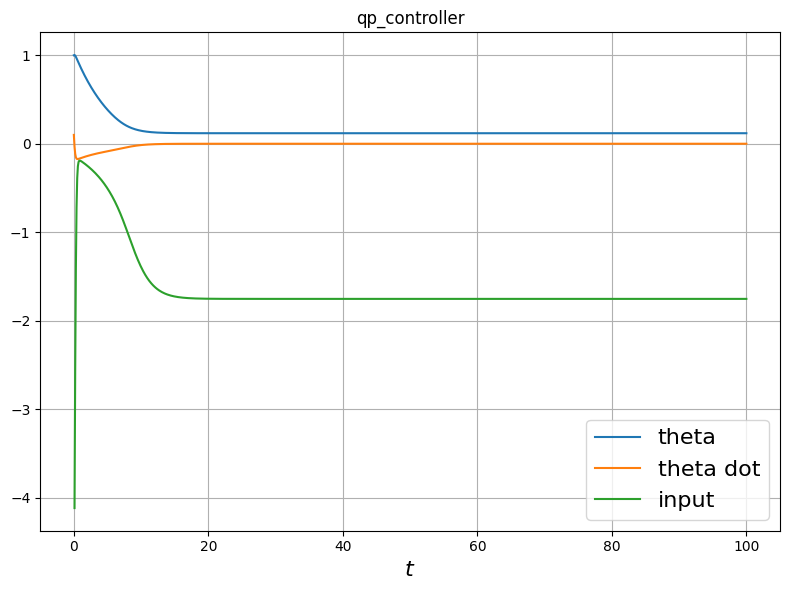

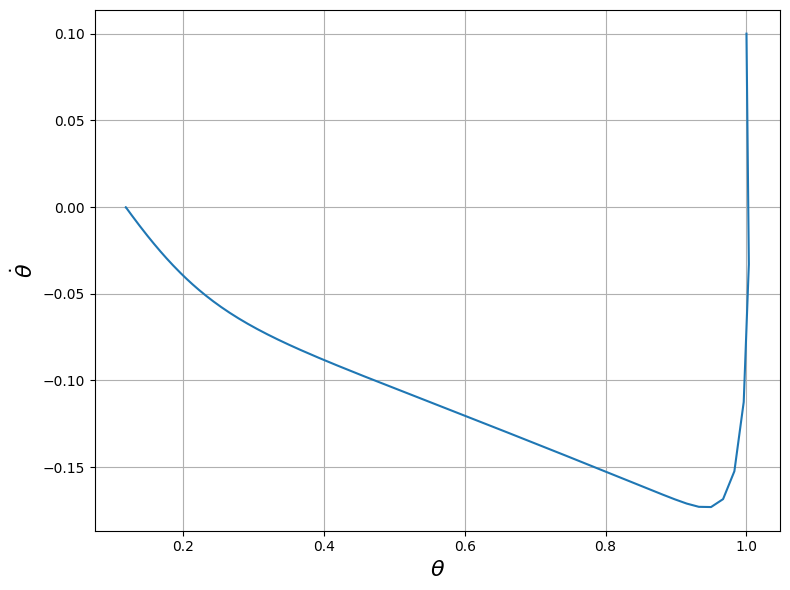

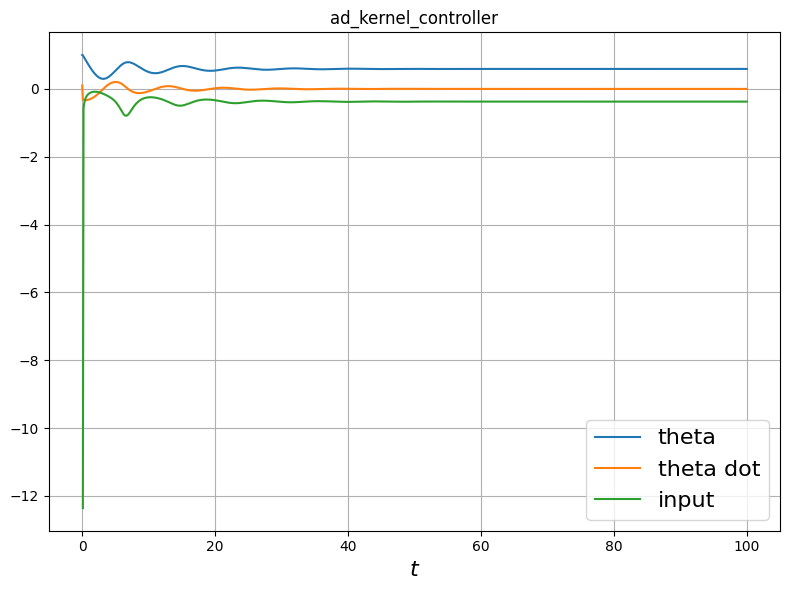

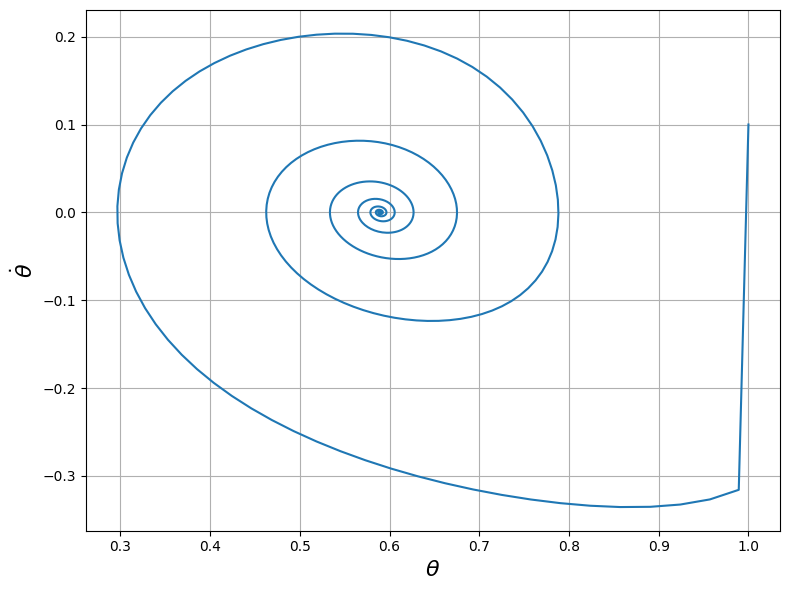

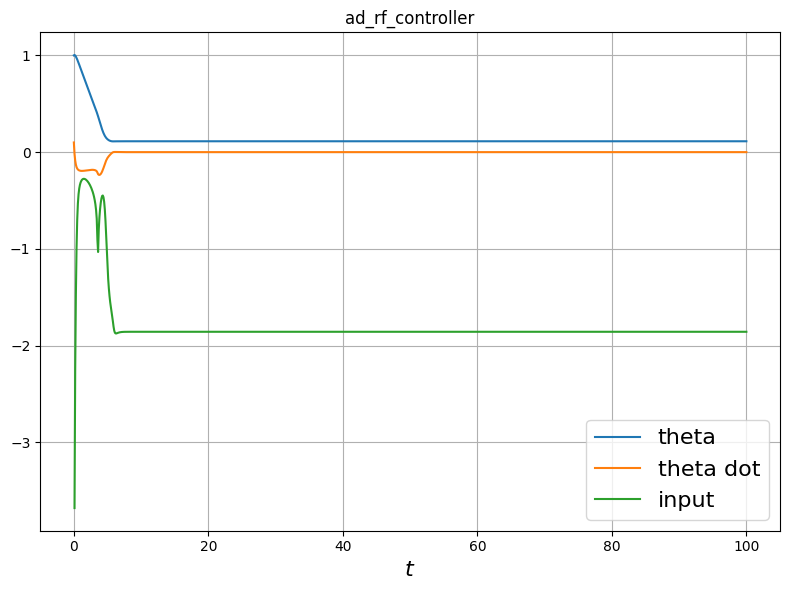

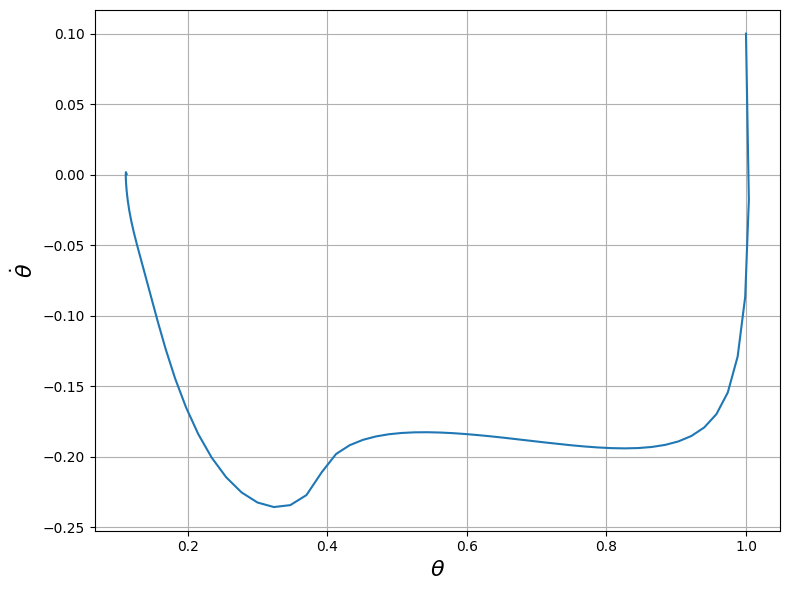

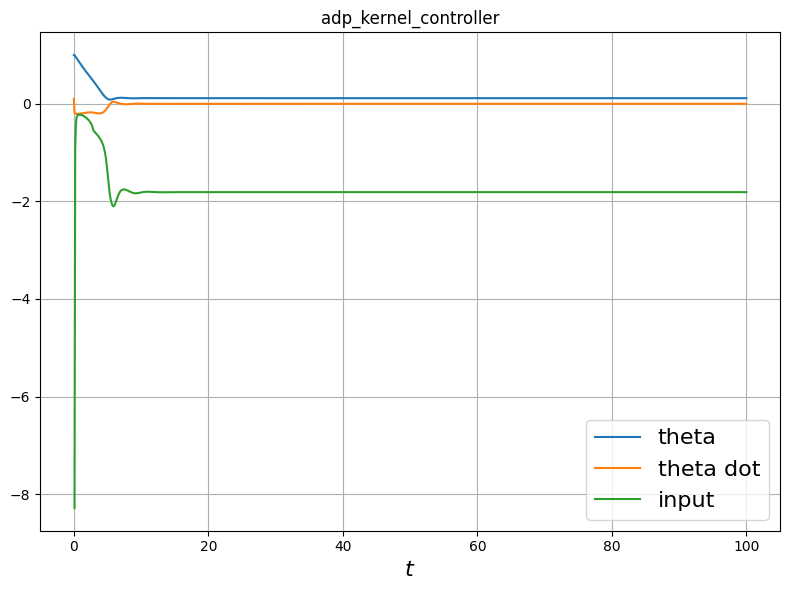

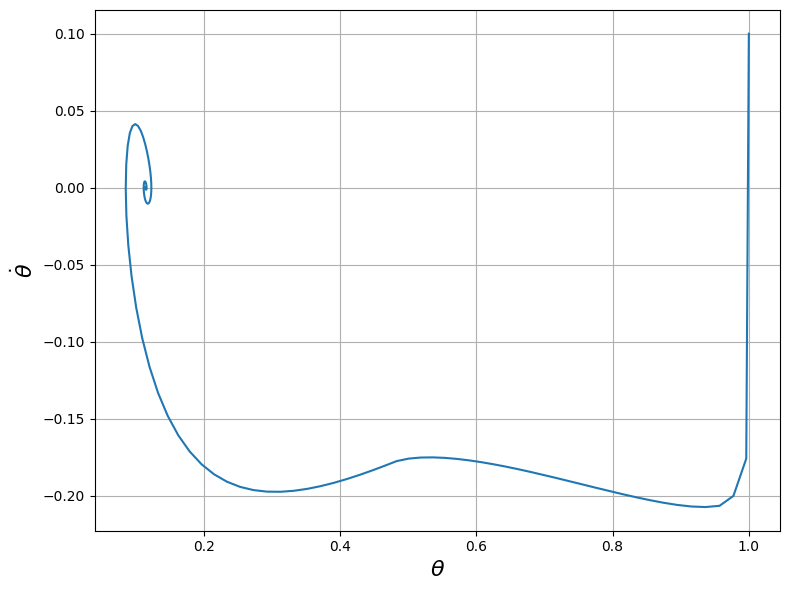

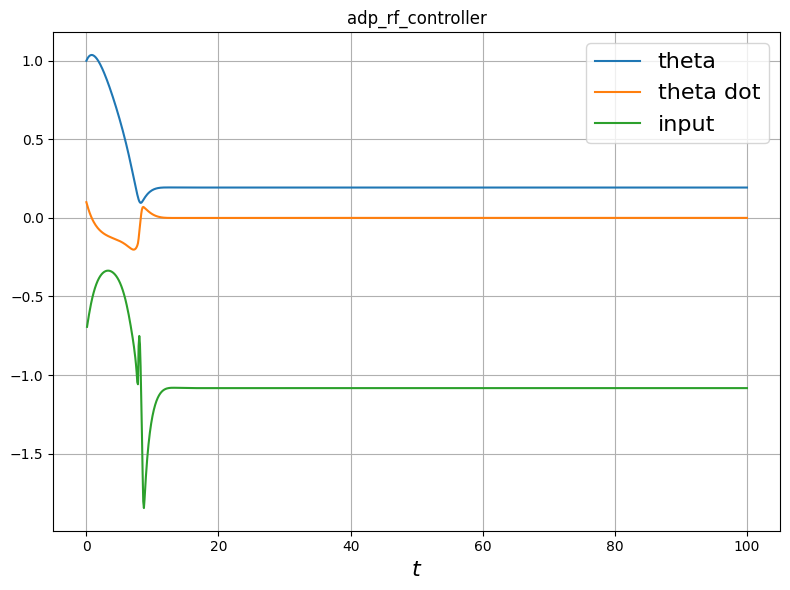

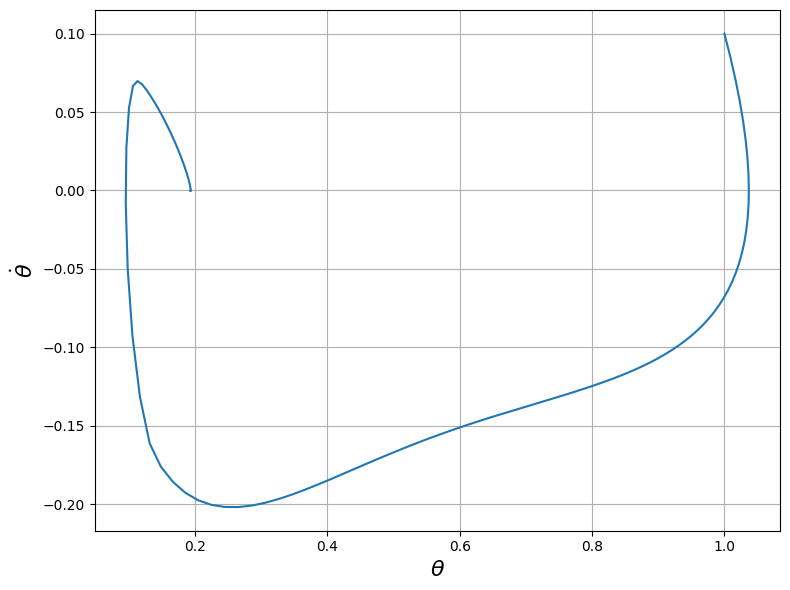

In [7]:
invp.plots()